# DSM - Modelling

- ploltting.py is imported to facilitate in visualization


$ (0) \quad \dot{E}_{t} \quad = \quad demand_{t} \quad + \quad DSM_{t}^{up} \quad - \quad
        \sum_{tt=t-L}^{t+L} DSM_{t,tt}^{do}  \qquad \forall t  $

### Formulation after Zerrahn & Schill
        
$ (1) \quad DSM_{t}^{up} \quad = \quad \sum_{tt=t-L}^{t+L} DSM_{t,tt}^{do}
        \qquad \forall t  $
        
$ (2) \quad DSM_{t}^{up} \quad \leq \quad E_{t}^{up} \qquad \forall t  $

$ (3) \quad \sum_{t=tt-L}^{tt+L} DSM_{t,tt}^{do} \quad \leq \quad E_{t}^{do}
        \qquad \forall tt $

$ (4) \quad DSM_{tt}^{up} \quad + \quad \sum_{t=tt-L}^{tt+L} DSM_{t,tt}^{do} \quad
        \leq \quad max \{ E_{t}^{up}, E_{t}^{do} \} \qquad \forall tt  $


**Table: Symbols and attribute names of variables V and parameters P**

|symbol             | attribute         | type|explanation|
|-------------------|-------------------|----|--------------------------------------|
|$DSM_{t}^{up} $    | `dsm_do[g,t,tt]  `| $V$| DSM up shift (additional load)       |
|$DSM_{t,tt}^{do}$  | `dsm_up[g,t]`     | $V$| DSM down shift (less load)           |
|$\dot{E}_{t} $     |`flow[g,t]`        | $V$| Energy flowing in from electrical bus|
|$L$                |`delay_time`       | $P$| Delay time for load shift            |
|$demand_{t} $      |  `demand[t]`      | $P$| Electrical demand series             |
|$E_{t}^{do}$       |`capacity_down[tt]`| $P$| Capacity DSM down shift              |
|$E_{t}^{up} $      |`capacity_up[tt]`  | $P$| Capacity DSM up shift                |

## Imports

In [1]:
from oemof import solph, outputlib
from oemof.network import Node
import pandas as pd
import os

# plot_dsm.py
import plotting as plt_dsm
import matplotlib.pyplot as plt

In [2]:
## base dataset
plt_dsm.make_directory('graphics')

----------------------------------------------------------
Created folder "graphics" in current directory.
----------------------------------------------------------


## Energy Model
For the testing, a basic energy system was set up including:

- Coal PP
- Wind PP
- PV PP
- DSM Sink
- shortage
- excess


In [3]:
def create_model(data, datetimeindex, directory, project, method, delay_time, shift_interval):
    

    # ----------------- Energy System ----------------------------
    
    # Create Energy System
    es = solph.EnergySystem(timeindex=datetimeindex)
    Node.registry = es

    # Create Busses
    b_coal_1 = solph.Bus(label='bus_coal_1')
    b_elec = solph.Bus(label='bus_elec')

    # Create Sources
    s_coal_p1 = solph.Source(label='source_coal_p1',
                             outputs={
                                b_coal_1: solph.Flow(
                                    nominal_value=10000,
                                    variable_costs=10)}
                             )

    s_wind = solph.Source(label='wind',
                          outputs={
                              b_elec: solph.Flow(
                                  actual_value=data['wind'][datetimeindex],
                                  fixed=True,
                                  nominal_value=1)}
                          )

    s_pv = solph.Source(label='pv',
                        outputs={
                            b_elec: solph.Flow(
                                actual_value=data['pv'][datetimeindex],
                                fixed=True,
                                nominal_value=1)}
                        )

    # Create Transformer
    cfp_1 = solph.Transformer(label='pp_coal_1',
                              inputs={b_coal_1: solph.Flow()},
                              outputs={
                                  b_elec: solph.Flow(
                                      variable_costs=0)},
                              conversion_factors={b_elec: 1}
                              )

    # Create DSM
    demand_dsm = solph.custom.SinkDSM(label='demand_dsm',
                                inputs={b_elec: solph.Flow(variable_costs=2)},
                                demand=data['demand_el'][datetimeindex],
                                capacity_up=data['Cap_up'][datetimeindex],
                                capacity_down=data['Cap_do'][datetimeindex],
                                method=method,
                                delay_time=delay_time,
                                shift_interval=shift_interval,
                                #recovery_time=1
                                )

    # Backup excess / shortage
    excess = solph.Sink(label='excess_el',
                        inputs={b_elec: solph.Flow(variable_costs=1)}
                        )

    s_shortage_el = solph.Source(label='shortage_el',
                                 outputs={
                                     b_elec: solph.Flow(
                                         variable_costs=200)}
                                 )

    # -------------------------- Create Model ----------------------

    # Create Model
    model = solph.Model(es)

    # Solve Model
    model.solve(solver='cbc', solve_kwargs={'tee': False})

    # Write LP File
    filename = os.path.join(os.path.dirname('__file__'), directory, project +'.lp')
    model.write(filename, io_options={'symbolic_solver_labels': True})

    # Save Results
    es.results['main'] = outputlib.processing.results(model)
    es.dump(dpath=None, filename=None)

    return model

## Presets

In [4]:
def start_model(df_data, timesteps, **kwargs):
    
    method  = kwargs.get('method', None)
    delay_time = kwargs.get('delay_time', None)
    shift_interval = kwargs.get('shift_interval', None)
    show = kwargs.get('show', False)
    plot = kwargs.get('plot', False)
    figure_size = kwargs.get('figsize', (10,10))
    
    # ----------------- Input Data & Timesteps ----------------------------

    # Provide directory
    project = 'demand_shift_test'
    directory = './'

    # Data manipulation
    data = df_data

    # Timestamp
    datetimeindex = pd.date_range(start='1/1/2013',
                                  periods=timesteps,
                                  freq='H')
    
    # ----------------- Create & Solve Model ----------------------------

    # Create model
    model = create_model(data,
                         datetimeindex,
                         directory,
                         project,
                         method,
                         delay_time,
                         shift_interval)


    # Get Results
    es = solph.EnergySystem()
    es.restore(dpath=None, filename=None)

    # Export data
    df_gesamt = plt_dsm.extract_results(model)

    # write data in csv
    #df_gesamt.to_csv(directory + project + '_data_dump.csv')
    
    # ----------------- Plot Results ----------------------------
    # Plot
    plt_dsm.plot_dsm(df_gesamt,
            datetimeindex,
            directory,
            timesteps,
            project,
            days=2,
            show=show,
            figsize=figure_size)
    return df_gesamt

## base dataset
For the limitations of the formulation this test dataset is modified.

In [5]:
timesteps = 48
# test data base
demand = [100] * timesteps
pv = [0] * timesteps
capup = [100] * timesteps
capdo = [100] * timesteps
wind = [100] * timesteps
# 
base = [demand, wind, capup, capdo, pv]
df_base = pd.DataFrame(list(zip(*base)))
df_base.rename(columns={0:'demand_el',1:'wind', 2:'Cap_up', 3:'Cap_do', 4:'pv'}, inplace=True)
df_base['timestamp'] = pd.date_range(start='1/1/2013', periods=timesteps, freq='H')
df_base.set_index('timestamp', drop=True, inplace=True)


# How it should work:

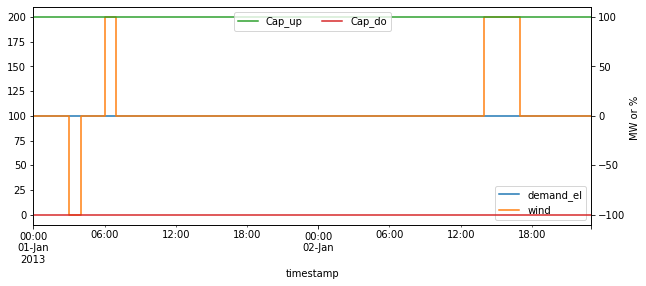

In [6]:
# data preperation
wind = [100] * timesteps
###### edit specifics

# triple extended
wind[3:4] = [0]
wind[38:41] = [200] * 3

#  interupting event
wind[6:7] = [200]

df_data = df_base.copy()
df_data['wind'] = wind

#plot
fig, ax = plt.subplots(figsize=(10,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax.set_yticks(range(-100,150,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("MW or % ")
plt.show()

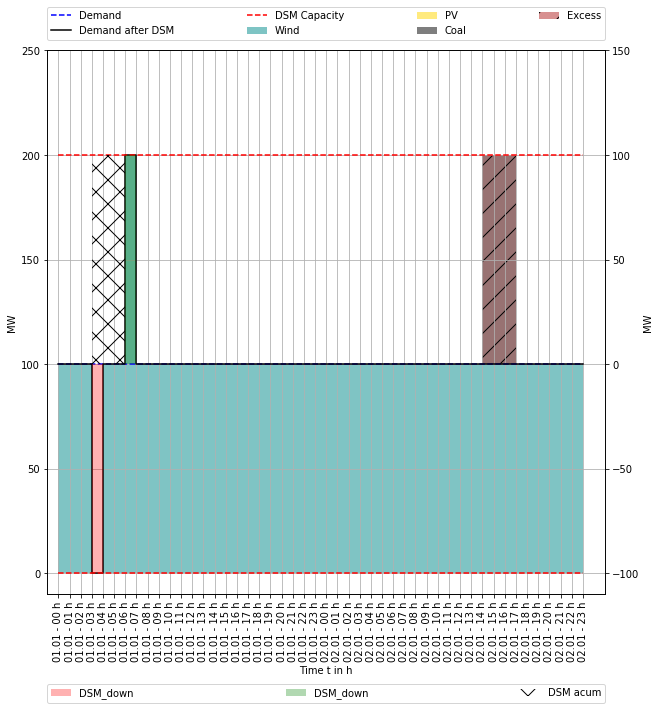

In [7]:
# start model
_ = start_model(df_data, timesteps, plot=True, method='delay', delay_time=3)

# limitations of the formulation


To preserve the formulation as a linear problem, the simultaneous activation of "DSM Up & Down" cannot be completely prevented. A possible solution with SOS-Variables would end up in a non-convex mixed integer programming problem. Thus leading to an increase in computing time.


## extended delay

Equation $(4)$ limits the sum of $DSM_{t}^{up} $  & $DSM_{t}^{down} $ to the value of the max capcacity.

$ (4) \quad DSM_{tt}^{up} \quad + \quad \sum_{t=tt-L}^{tt+L} DSM_{t,tt}^{do} \quad
        \leq \quad max \{ E_{t}^{up}, E_{t}^{do} \} \qquad \forall tt  $


If this capacity isn't fullly used, the remaining potential $ E_{x}-DSM^{x} = \Delta $ might be used to artificially extend the delay time if Equation $(0)$ is not violated.

$ (0) \quad demand_{t}  \quad = \quad  \dot{E}_{t}  \quad - \quad DSM_{t}^{up} \quad + \quad
        \sum_{tt=t-L}^{t+L} DSM_{t,tt}^{do}  \qquad \forall t  $
        
This is the the case if the remaining potential is split in half and added to both variables.


$ (0) \quad demand_{t} \quad = \quad \dot{E}_{t}\quad - \quad (DSM_{t}^{up} + \frac{1}{2} \cdot \Delta) \quad + \quad
        (\sum_{tt=t-L}^{t+L} DSM_{t,tt}^{do} +\frac{1}{2} \cdot \Delta)  \qquad \forall t  $

In the following, there will be some showcases presenting the problem and its influence. 

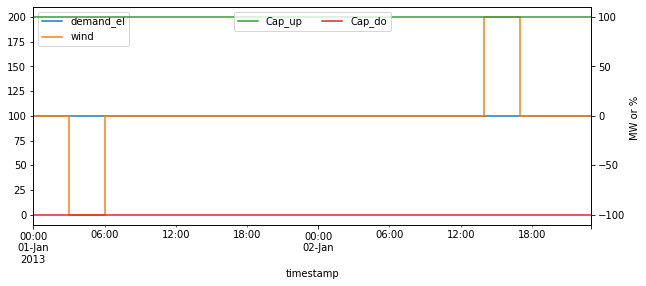

In [8]:
# data preperation
wind = [100] * timesteps
###### edit specifics

# triple extended
wind[3:6] = [0] * 3
wind[38:41] = [200] * 3

# no interupting event
df_data = df_base.copy()
df_data['wind'] = wind

#plot
fig, ax = plt.subplots(figsize=(10,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax.set_yticks(range(-100,150,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("MW or % ")
plt.show()

- 100 MW constant demand
- 100 MW missing supply from 3 h to 6 h
- 100 MW surpluss from 14 h to 17 h the next day
- The delay time is set to 1 h.

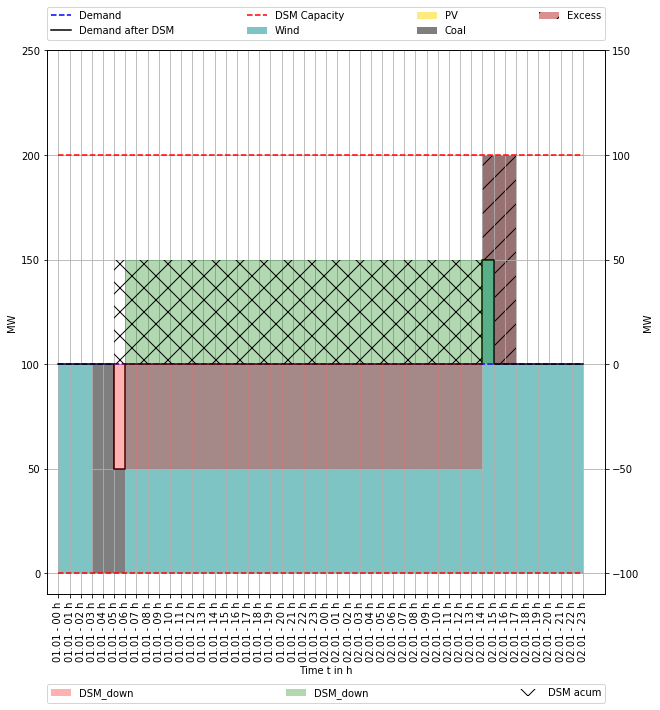

In [9]:
# start model
_ = start_model(df_data, timesteps, plot=True, method='delay', delay_time=1)

### what should happen:

- no demand shift, as the delay time could only be realised with a delay time of 32h
- missing demand should be fully compensated by coal power plant
- surpluss should go to excess
### what happens:

- 50 MW of demand is shifted
- demand shift takes place over 32 h

### why:

- $DSM_{t}^{up} $  & $DSM_{t}^{down} $ can be non-zero at the same time.
- the sum of $DSM_{t}^{up} $  & $DSM_{t}^{down} $ is limited to 100 MW. Eq. (4)
    - as there is no other demand shift happening $\Delta  = 100MW$
- $DSM_{7-32}^{up} $  & $DSM_{7-32}^{down} $ can be 50 MW at the same time.



- 50% of the remaining capacity $\Delta$ can be used to extend the delay if there is no interupting event and suits the overall objective (e.g. min_cost)

## when does it happen:

- if there is any $ \Delta > 0 $ which can be compensated

- depending on the delay time

    - for $t_{delay} < dist < \infty$
    
         delay time of $n$ can overcome $\frac{n}{2}$ fully used potential 
         
    - for $ dist \leq t_{delay}  $
        
         delay time of $n$ can overcome $\frac{n}{2} + 0.5 \cdot x $ fully used potential x = |c_dist < delaytime|
        


### Interrupting event
interupting event with -50 % wind after 1 timestep

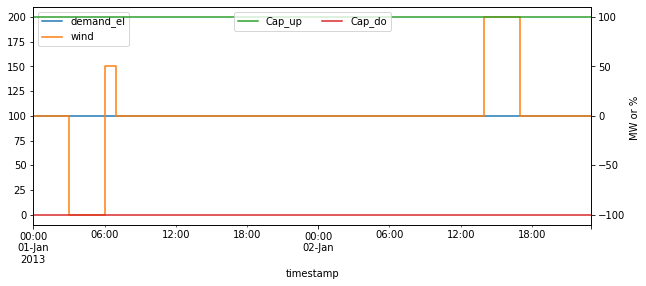

In [10]:
# data preperation
wind = [100] * timesteps
###### edit specifics
# triple extended
wind[3:6] = [0] * 3
wind[38:41] = [200] * 3

# interupting event after 1 timestep
wind[6:7] = [150]

df_data = df_base.copy()
df_data['wind'] = wind

# plot
fig, ax = plt.subplots(figsize=(10,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax.set_yticks(range(-100,150,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("MW or % ")
plt.show()

- 100 MW constant demand
- 100 MW missing supply from 3 h to 6 h
- 100 MW surpluss from 14 h to 17 h the next day
- 50 MW surplus from 6 h to 7h
- The delay time is set to 1 h

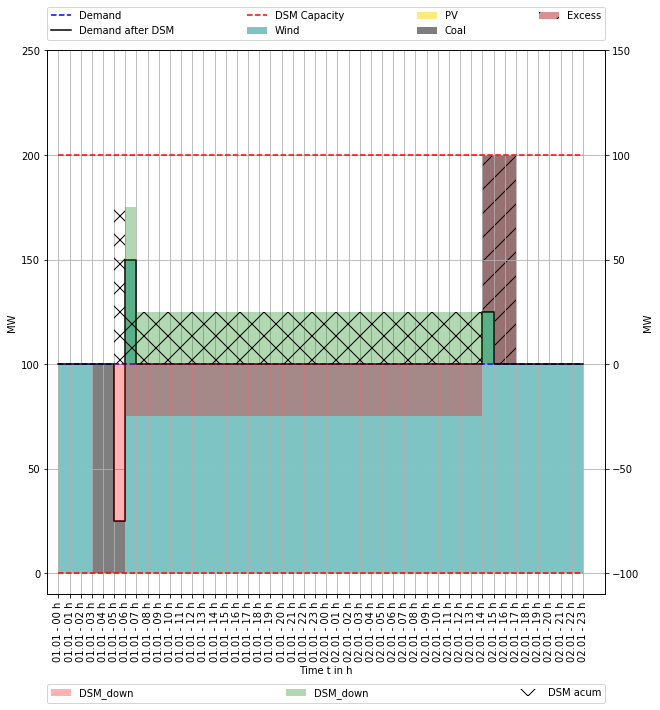

In [11]:
# start model
_ = start_model(df_data, timesteps, plot=True, method='delay', delay_time=1)

### what should happen:

- 50 MW should be shifted in between 6 h and 7h as the delay time is 1 h
- missing demand should be fully compensated by coal power plant
- surpluss should fully go to excess

### what happens:

- 50 MW of demand are shifted betwenn 6h and 7 h 
- 25 MW additional demand shift takes place over 32 h

### why:

- $DSM_{t}^{up} $  & $DSM_{t}^{down} $ can be non-zero at the same time.
- 50 MW demand shift is happening.
- the sum of $DSM_{t}^{up} $  & $DSM_{t}^{down} $ is limited to 100 MW.
    -  there is still 50 MW of potential left at 7 h.  $\Delta  = 50MW$
    - $DSM_{7}^{up} = \, 75 MW $  
    - $DSM_{7}^{down} = \, 25 MW $
    - $Eq. \, (4) \quad DSM_{t}^{up} \quad + \quad \sum_{t=tt-L}^{tt+L} DSM_{t,tt}^{do} \quad
        \leq \quad max \{ E_{t}^{up}, E_{t}^{do} \} \qquad \forall tt  $
- $ Eq. (0) \quad demand_{t} \quad = \quad \dot{E}_{t}\quad - \quad (DSM_{t}^{up} + \frac{1}{2} \cdot \Delta) \quad + \quad
        (\sum_{tt=t-L}^{t+L} DSM_{t,tt}^{do} +\frac{1}{2} \cdot \Delta)  \qquad \forall t  $    

## influence of the delay time
varying delay time

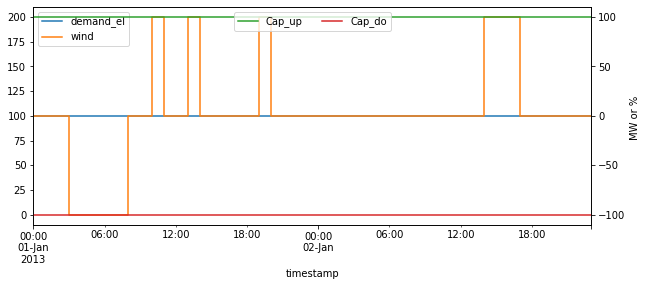

In [12]:
# data preperation
wind = [100] * timesteps
###### edit specifics
# triple extended
wind[3:8] = [0] * 5
wind[38:41] = [200] * 3
# interupting event
wind[10:11] = [200]

wind[13:14] = [200]

wind[19:20] = [200]

# plot
df_data = df_base.copy()
df_data['wind'] = wind
fig, ax = plt.subplots(figsize=(10,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True)
ax.set_yticks(range(-100,150,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("MW or % ")
plt.show()

- 100 MW constant demand
- 100 MW missing supply from 3 h to 8 h
- 100 MW surplus from 10 h to 13 h the next day. (after 32h)
- 100 MW surplus from 10 h to 11 h (c_dist = 3)
- 100 MW surplus from 13 h to 14 h (c_dist = 5
- 100 MW surplus from 19 h to 20 h (c_dist = 21)
- The delay time is set to 1 h

### when does it happen:
- if there is any $ \Delta > 0 $ which can be compensated
- depending on the delay time

    - for $t_{delay} < dist < \infty$
    
         delay time of $n$ can overcome $\frac{n}{2}$ fully used potential 
         
    - for $ dist \leq t_{delay}  $
        
         delay time of $n$ can overcome $\frac{n}{2} + 0.5 \cdot x $ fully used potential x = |c_dist < delaytime|
        


## iteration over delay_time

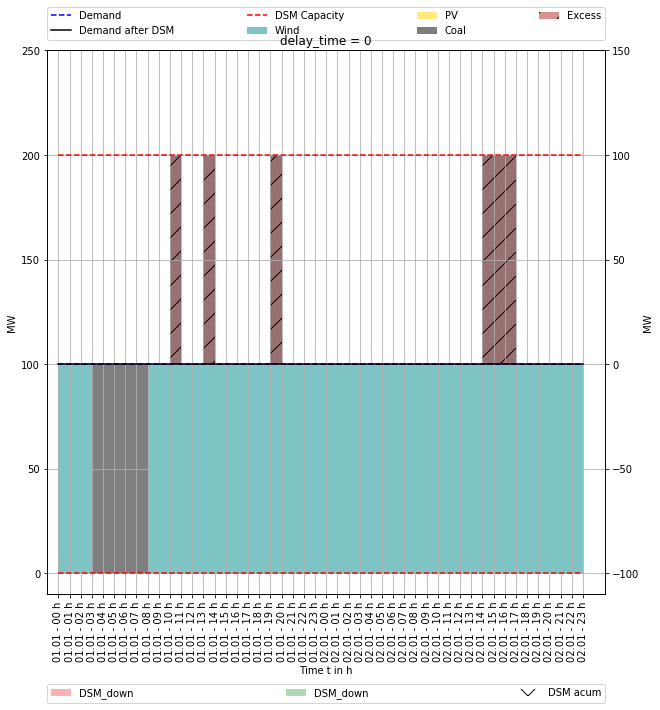

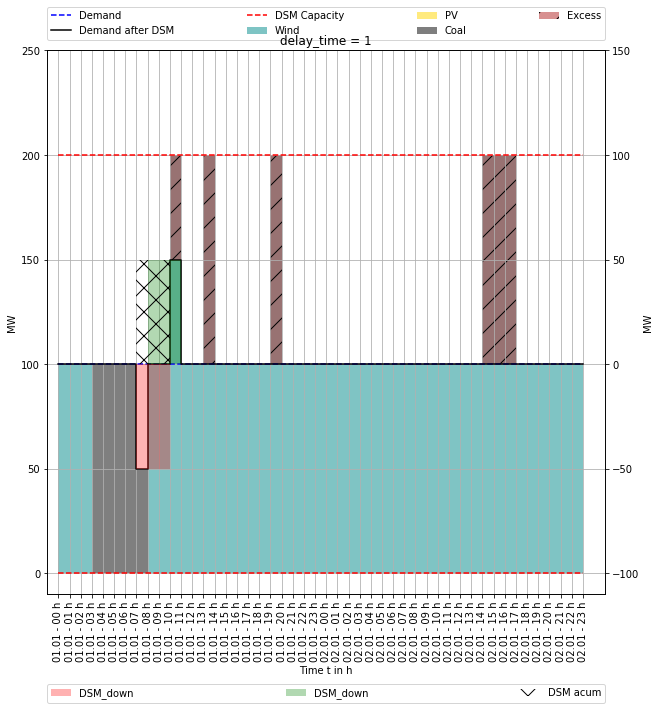

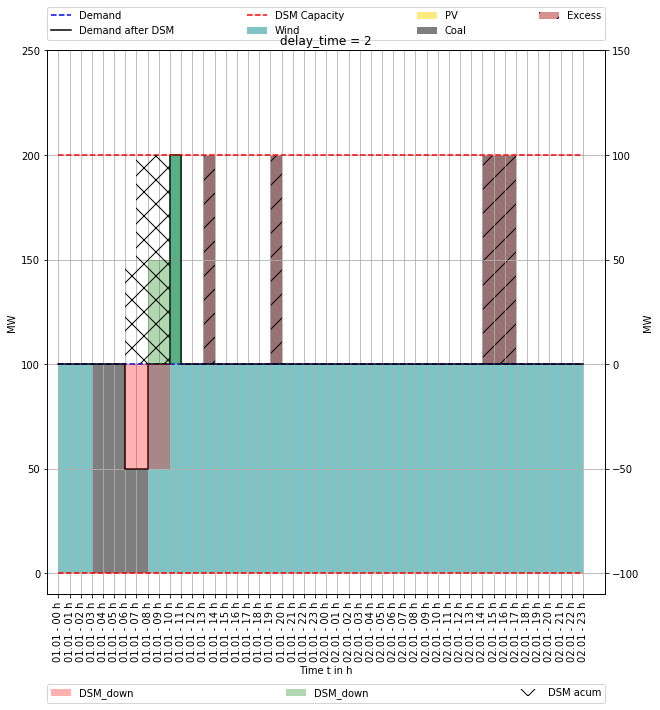

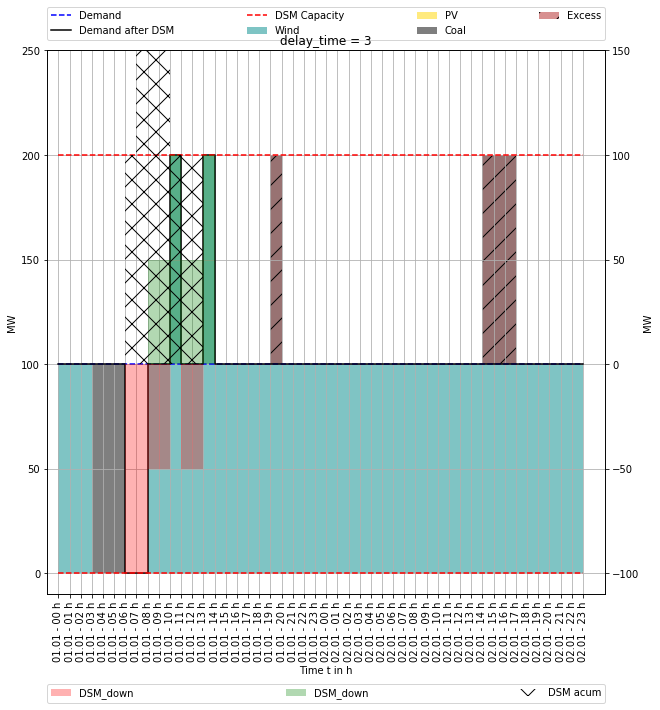

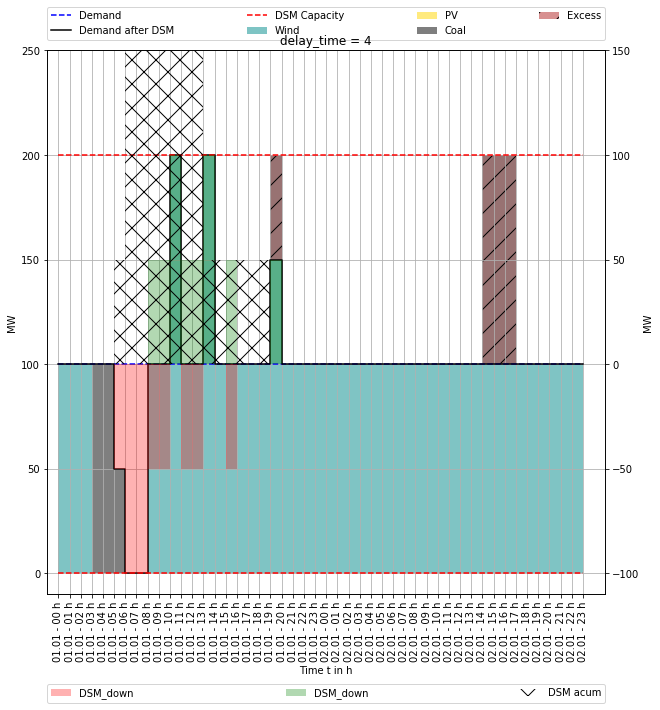

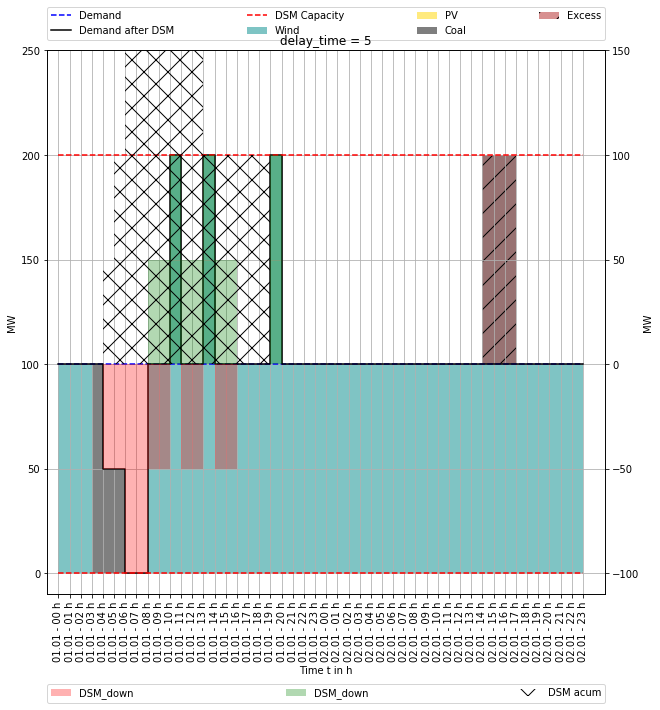

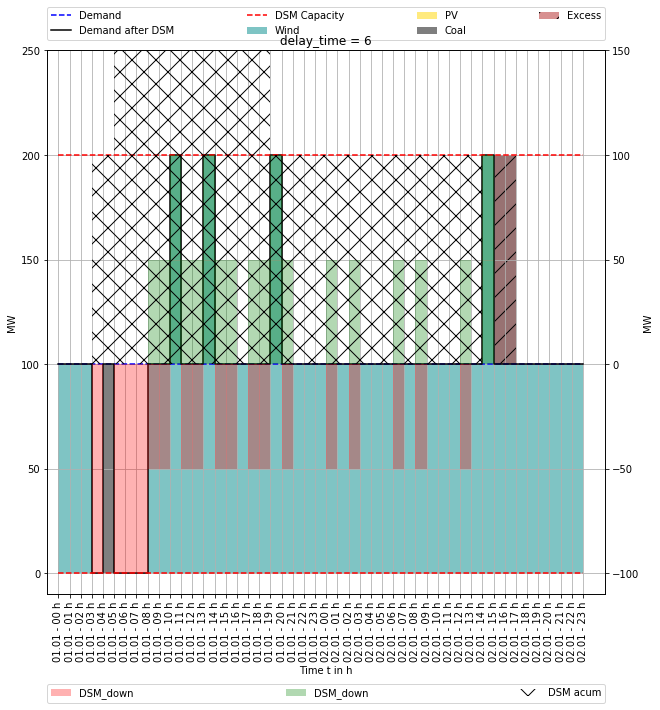

In [13]:
# start model
for i in range(7):
    _ = start_model(df_data, timesteps, plot=True, method='delay', delay_time=i, figsize=(5,5))
    plt.title('delay_time = ' + str(i))